In [1306]:
import pandas as pd
import numpy as np

### Loading the feature functions from CSV and trimming

In [1307]:
df = pd.read_csv("features/ff_valence.csv")

# Save to a CSV file
molecules = df['Mol'].values


molecules = molecules
molecules

array(['LiH', 'NaH', 'KH', 'RbH', 'CsH', 'CsCl', 'LiCl', 'CuI', 'LiF',
       'ZnS', 'CoO2', 'SnS2', 'LiCoO2', 'LiSnS2'], dtype=object)

### Size Modification and adding parameters to Data Frame

In [1308]:
df

,Mol,Pol_C,Pol_A,RadV_C,RadV_A,CN_C,CN_A,Ion_C,Ion_A,EA_C,EA_A,EN_C,EN_A
0,LiH,164.10,4.51,133.0,32,6,6,5.3920,13.590,0.7540,0.618,0.98,2.200
1,NaH,162.70,4.51,155.0,32,6,6,5.1390,13.590,0.7540,0.548,0.93,2.200
2,KH,289.70,4.51,196.0,32,6,6,4.3410,13.590,0.7540,0.501,0.82,2.200
3,RbH,319.80,4.51,210.0,32,6,6,4.1770,13.590,0.7540,0.468,0.82,2.200
4,CsH,400.60,4.51,232.0,32,6,6,3.8490,13.590,0.7540,0.472,0.79,2.200
5,CsCl,400.60,14.60,232.0,99,8,8,3.8490,12.960,3.6170,0.472,0.79,3.160
6,LiCl,164.10,14.60,133.0,99,6,6,5.3920,12.960,3.6170,0.618,2.20,3.160
7,CuI,46.50,32.90,112.0,133,4,4,7.7260,10.451,3.0590,1.228,1.90,2.660
8,LiF,164.10,3.74,133.0,64,6,6,5.3920,17.423,3.3390,0.618,2.20,3.980
9,ZnS,38.67,19.40,118.0,103,4,4,9.3940,10.360,0.0000,2.077,1.65,2.580


In [1309]:

%store -r res
res

[14.133308154469557,
 14.081369567351956,
 14.034265054162482,
 12.926169405830962,
 12.27212198878638,
 3.230739472566894,
 5.121300394981286,
 3.5739198265668453,
 4.715887333726234,
 2.499975609761724,
 1.8052940594169544,
 1.096295429346349,
 5.560246204451975,
 3.4399161501869044]

In [1310]:
# df = df.iloc[:10,0:]


## always inverse of EN_A

# df['Sum_EN'] = df['EN_C'] + df['EN_A']
# df['Diff_EN'] = abs(df['EN_A'] - df['EN_C'])
# # df['Diff_rad'] = df['RadV_A'] - df['RadV_C']


df['Sum_ion'] = df['Ion_C'] + df['Ion_A']
df['Sum_ion_cubed'] = df['Sum_ion']*df['Sum_ion']*df['Sum_ion']

df['Abs_diff_ion'] = abs(df['Ion_C'] - df['Ion_A'])
df['Abs_diff_ion_cubed'] = df['Abs_diff_ion']*df['Abs_diff_ion']*df['Abs_diff_ion']

# df.drop(columns=['Abs_diff_ion','Sum_ion'])

df['Sum_EN'] = df['EN_A'] + df['EN_C']
df['Sum_EN_cubed'] = df['Sum_EN']*df['Sum_EN']*df['Sum_EN']

df['Abs_diff_EN'] = abs(df['EN_A'] - df['EN_C'])
df['Abs_diff_EN_cubed'] = df['Abs_diff_EN']*df['Abs_diff_EN']*df['Abs_diff_EN']

# df.drop(columns=['Sum_EN','Abs_diff_EN'])

# df['Sum_pol'] = df['Pol_C'] + df['Pol_A']
# df['Sum_pol_cubed'] = df['Sum_pol']*df['Sum_pol']*df['Sum_pol']

# df['Abs_diff_pol'] = abs(df['Pol_C'] - df['Pol_A'])
# df['Abs_diff_pol_cubed'] = df['Abs_diff_pol']*df['Abs_diff_pol']*df['Abs_diff_pol']


# Adding sqrt values for each column
# for col in df.columns:
#     # Make sure the column is numeric before applying sqrt
#     if pd.api.types.is_numeric_dtype(df[col]):
#         # df[f'{col}_sqrt'] = np.sqrt(abs(df[col]))
#         # df[f'{col}_squared'] = np.square(df[col])
#         df.drop(columns=[col], inplace=True)

# df = df.drop(columns=['EN_C'])

# df['sum_ion'] = df['Ion_C'] + df['Ion_A']
# # df['diff_ion'] = df['Ion_C'] - df['Ion_A']
# df['diff_pol'] = abs(df['Pol_C'] - df['Pol_A'])

# df = df[['EA_A's]]

# df = df[['Sum_ion_cubed','Abs_diff_ion_cubed','Sum_EN_cubed','Abs_diff_EN_cubed','EN_C','EN_A','Ion_C','Ion_A']]


df['Abs_diff_radV'] = abs(df['RadV_A'] - df['RadV_C'])
df['Abs_diff_radV'] = df['Abs_diff_radV']*df['Abs_diff_radV']
# df['Abs_diff_radI'] = abs(df['RadI_A'] - df['RadI_C'])

df['Sum_radV'] = df['RadV_A'] + df['RadV_C']
df['Sum_radV'] = df['Sum_radV']*df['Sum_radV']

df['Exp_rad'] = 1/np.exp(-(df['Sum_radV'])/100000) 
# df['Sum_radI'] = df['RadI_A'] + df['RadI_C']

df.shape

(14, 24)

In [1311]:
df = df[['CN_A','CN_C']]
df

,CN_A,CN_C
0,6,6
1,6,6
2,6,6
3,6,6
4,6,6
5,8,8
6,6,6
7,4,4
8,6,6
9,4,4


### making the combinations

In [1312]:
import itertools
import numpy as np
import pandas as pd
from multiprocessing import Pool, cpu_count

In [1313]:
import itertools
import numpy as np
import pandas as pd

def generate_combinations_df(params_df, param_names):
    results = []

    # Convert all parameter values to numeric, coercing errors to NaN
    params_df = params_df.apply(pd.to_numeric, errors='coerce')

    # Precompute inverses of all parameters
    params_inv_df = params_df.applymap(lambda x: np.power(float(x), -1) if pd.notnull(x) and x != 0 else np.nan)
    params_inv_df.columns = [f"{name}^(-1)" for name in param_names]

    # Combine original parameters and their inverses
    combined_params_df = pd.concat([params_df, params_inv_df], axis=1)
    combined_param_names = list(combined_params_df.columns)

    # Precompute invalid pairs (parameter and its inverse)
    invalid_pairs = {f"{name}^(-1)": name for name in param_names}
    invalid_pairs.update({name: f"{name}^(-1)" for name in param_names})

    # Generate all subsets of parameters (combinations)
    for r in range(1, len(combined_param_names) + 1):
        for subset_indices in itertools.combinations(range(len(combined_param_names)), r):

            subset_names = [combined_param_names[i] for i in subset_indices]

            # Skip invalid subsets early
            if any(invalid_pairs.get(name) in subset_names for name in subset_names):
                continue

            # Select the subset DataFrame
            subset = combined_params_df[subset_names]

            # Replace NaN values with 0
            subset = subset.fillna(0)

            # Compute results for valid subsets
            expr_str = " * ".join(subset_names)
            expr_val = subset.prod(axis=1)
            results.append((expr_str, expr_val))

    return results


In [1314]:
import itertools
import numpy as np
import pandas as pd

def generate_combinations_df(params_df, param_names, restricted_properties=None, restricted_to_inverses=None):
    if restricted_properties is None:
        restricted_properties = []
    if restricted_to_inverses is None:
        restricted_to_inverses = []

    results = []

    # Convert all parameter values to numeric, coercing errors to NaN
    params_df = params_df.apply(pd.to_numeric, errors='coerce')

    # Precompute inverses of all parameters
    params_inv_df = params_df.applymap(lambda x: np.power(float(x), -1) if pd.notnull(x) and x != 0 else np.nan)
    params_inv_df.columns = [f"{name}^(-1)" for name in param_names]

    # Combine original parameters and their inverses
    combined_params_df = pd.concat([params_df, params_inv_df], axis=1)
    combined_param_names = list(combined_params_df.columns)

     # Precompute invalid pairs (parameter and its inverse)
    invalid_pairs = {f"{name}^(-1)": name for name in param_names}
    invalid_pairs.update({name: f"{name}^(-1)" for name in param_names})
    
    # Generate all subsets of parameters (combinations)
    for r in range(1, len(combined_param_names) + 1):
        for subset_indices in itertools.combinations(range(len(combined_param_names)), r):
            subset_names = [combined_param_names[i] for i in subset_indices]

            # Replace NaN values with 0
             # Skip invalid subsets early
            if any(invalid_pairs.get(name) in subset_names for name in subset_names):
                continue
            
            subset = combined_params_df[subset_names]
            subset = subset.fillna(0)

            # Check if both a parameter and its inverse are in the subset
            invalid = False
           
            # Exclude subsets containing restricted inverses
            for restricted in restricted_properties:
                if f"{restricted}^(-1)" in subset_names:
                    invalid = True
                    break

            # Ensure restricted properties only appear as inverses
            for restricted in restricted_to_inverses:
                if restricted in subset_names or (restricted not in param_names and f"{restricted}^(-1)" not in subset_names):
                    invalid = True
                    break

            if invalid:
                continue

            # Compute results for valid subsets
            expr_str = " * ".join(subset_names)
            expr_val = subset.prod(axis=1)
            results.append((expr_str, expr_val))
            expr_str = " + ".join(subset_names)
            expr_val = subset.sum(axis=1)
            results.append((expr_str, expr_val))

    return results


In [1315]:
import itertools
import numpy as np
import pandas as pd
from multiprocessing import Pool, cpu_count

def process_combinations_chunk(args):
    combined_params_df, combined_param_names, param_names, indices_chunk = args
    results = []

    for indices in indices_chunk:
        subset_names = [combined_param_names[i] for i in indices]
        subset = combined_params_df[subset_names]

        # Replace NaN values with 0
        subset = subset.fillna(0)

        # Check if both a parameter and its inverse are in the subset
        invalid = False
        for name in subset_names:
            if name.endswith("^(-1)") and name[:-5] in subset_names:
                invalid = True
                break
            elif name in param_names and f"{name}^(-1)" in subset_names:
                invalid = True
                break

        if not invalid:
            # Compute results for valid subsets
            expr_str = " * ".join(subset_names)
            expr_val = subset.prod(axis=1)
            results.append((expr_str, expr_val))

    return results

def generate_combinations_df_parallel(params_df, param_names):
    # Convert all parameter values to numeric, coercing errors to NaN
    params_df = params_df.apply(pd.to_numeric, errors='coerce')

    # Precompute inverses of all parameters
    params_inv_df = params_df.applymap(lambda x: np.power(float(x), -1) if pd.notnull(x) and x != 0 else np.nan)
    params_inv_df.columns = [f"{name}^(-1)" for name in param_names]

    # Combine original parameters and their inverses
    combined_params_df = pd.concat([params_df, params_inv_df], axis=1)
    combined_param_names = list(combined_params_df.columns)

    # Generate all subsets of parameter indices
    all_combinations = [
        indices for r in range(1, len(combined_param_names) + 1)
        for indices in itertools.combinations(range(len(combined_param_names)), r)
    ]

    # Divide all_combinations into chunks
    num_workers = min(cpu_count(), len(all_combinations))
    chunk_size = max(1, len(all_combinations) // num_workers)
    chunks = [all_combinations[i:i + chunk_size] for i in range(0, len(all_combinations), chunk_size)]

    print(f"Using {num_workers} workers to process {len(all_combinations)} combinations in {len(chunks)} chunks")

    # Prepare arguments for parallel processing
    args = [
        (combined_params_df, combined_param_names, param_names, chunk)
        for chunk in chunks
    ]

    # Use multiprocessing to process combinations in parallel
    with Pool(processes=num_workers) as pool:
        results = pool.map(process_combinations_chunk, args)

    # Flatten results
    flattened_results = [item for sublist in results for item in sublist]
    return flattened_results


### Restricted parameters

In [1316]:
# df = df.iloc[:,1:]
df

,CN_A,CN_C
0,6,6
1,6,6
2,6,6
3,6,6
4,6,6
5,8,8
6,6,6
7,4,4
8,6,6
9,4,4


In [1317]:
# numeretor = ['Ion_C','Ion_A']
# denomeretor = ['Abs_diff_pol','Sum_pol','Abs_diff_EN','Sum_EN']
numeretor = None
denomeretor = None

In [1318]:

import os
import pandas as pd

takeSaved = False

all_expressions = []
expressions = []
# Define file name to save/load the results
cache_file = "cached_expressions.pkl"

if os.path.exists(cache_file) and takeSaved:
    # Load the cached results if they exist
    expressions = pd.read_pickle(cache_file)
    all_expressions = list(expressions.itertuples(index=False, name=None))
    print("Loaded cached expressions.")
else:
    # Perform the costly computation if cache does not exist
    print("Calculating expressions...")
    param_names = list(df.columns)
    all_expressions = generate_combinations_df(df.iloc[:,:], param_names, restricted_properties=numeretor, restricted_to_inverses=denomeretor)
    expressions = pd.DataFrame(all_expressions, columns=['Expression', 'Value'])

    # Save the results to cache
    expressions.to_pickle(cache_file)
    print("Expressions cached.")

# Print the shape of the expressions DataFrame
print(expressions.shape)


Calculating expressions...
Expressions cached.
(16, 2)


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_96519/1368268208.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  params_inv_df = params_df.applymap(lambda x: np.power(float(x), -1) if pd.notnull(x) and x != 0 else np.nan)


In [1319]:
expressions['Value'] = expressions['Value'] 
expressions.head()

,Expression,Value
0,CN_A,0 6 1 6 2 6 3 6 4 6 5 ...
1,CN_A,0 6 1 6 2 6 3 6 4 6 5 ...
2,CN_C,0 6 1 6 2 6 3 6 4 6 5 ...
3,CN_C,0 6 1 6 2 6 3 6 4 6 5 ...
4,CN_A^(-1),0 0.166667 1 0.166667 2 0.166667 3...


### Addition results to the combinations

In [1320]:
values_dict = {expr_str: expr_val for expr_str, expr_val in all_expressions}
values = pd.DataFrame(values_dict)
values['res'] = res

### Finding Corelation

In [1321]:

correlation = values.corr()

correlation.shape

(13, 13)

In [1322]:
results=correlation['res'].abs().sort_values(ascending=False)
print(results.iloc[0:100])
top_vars = results.iloc[1:100].index

res                      1.000000
CN_A^(-1) * CN_C^(-1)    0.653383
CN_A^(-1) + CN_C^(-1)    0.628684
CN_A^(-1)                0.606562
CN_A                     0.555948
CN_A + CN_C^(-1)         0.555209
CN_C * CN_A^(-1)         0.541426
CN_A * CN_C^(-1)         0.537390
CN_A + CN_C              0.477018
CN_A * CN_C              0.425630
CN_C^(-1)                0.227007
CN_C                     0.131891
CN_C + CN_A^(-1)         0.052742
Name: res, dtype: float64


In [1323]:
filtered_expressions = [(name, values) for name, values in all_expressions if name in top_vars]

# To display the filtered results




### Final Results

In [1324]:
results=correlation['res'].abs().sort_values(ascending=False)
print(results.iloc[0:200])
top_vars = results.iloc[1:200].index


res                      1.000000
CN_A^(-1) * CN_C^(-1)    0.653383
CN_A^(-1) + CN_C^(-1)    0.628684
CN_A^(-1)                0.606562
CN_A                     0.555948
CN_A + CN_C^(-1)         0.555209
CN_C * CN_A^(-1)         0.541426
CN_A * CN_C^(-1)         0.537390
CN_A + CN_C              0.477018
CN_A * CN_C              0.425630
CN_C^(-1)                0.227007
CN_C                     0.131891
CN_C + CN_A^(-1)         0.052742
Name: res, dtype: float64


In [1390]:
param = top_vars[7]

y = values[param]
x = values['res']

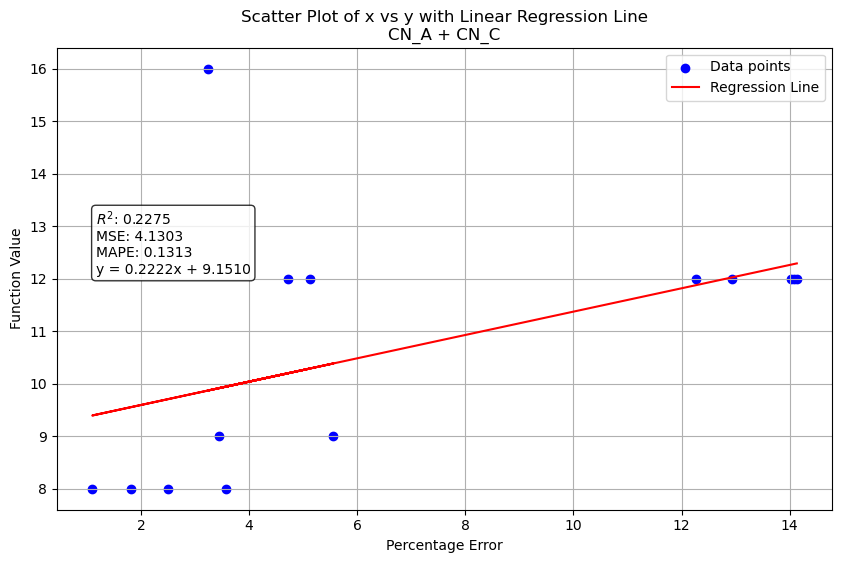

In [1391]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

# Reshape x to a 2D array
x_reshaped = x.values.reshape(-1, 1)  # Convert x to a 2D array (n, 1)

# Create and fit the linear regression model
model = LinearRegression()
model.fit(x_reshaped, y)

# Get the slope (coefficient) and intercept
slope = model.coef_[0]  # model.coef_ gives the slope of the line
intercept = model.intercept_  # model.intercept_ gives the intercept

# Predict y values using the linear model
y_pred = model.predict(x_reshaped)

# Calculate R^2, MSE, and MAPE
r_squared = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
mape = mean_absolute_percentage_error(y, y_pred)

# Display the equation of the line
equation = f"y = {slope:.4f}x + {intercept:.4f}"

# Plot the data points and the regression line
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='blue', label='Data points')
plt.plot(x, y_pred, color='red', label='Regression Line')
plt.title(f'Scatter Plot of x vs y with Linear Regression Line\n{param}')
plt.xlabel('Percentage Error')
plt.ylabel('Function Value')
plt.grid()
plt.legend()

# Add text box with metrics
textstr = f"$R^2$: {r_squared:.4f}\nMSE: {mse:.4f} \nMAPE: {mape:.4f}\n{equation}"
plt.gca().text(0.05, 0.65, textstr, transform=plt.gca().transAxes, fontsize=10,
               verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

plt.show()

### Results

1. Ion_C * EN_A * Sum_ion * Abs_diff_ion * Ion_A^(-1) * EN_C^(-1) * Sum_EN^(-1) * Abs_diff_EN^(-1) 

### Task

1. Check liturature for binary battery materials , check umbd paper

2. Test for more ionic compounds

Problem with D3(S) they only applied for molecular systems. Periodic systems are missing. We can include these periodic systems.

In [1392]:
import pandas as pd

# Convert your data to a DataFrame
df = pd.DataFrame(filtered_expressions)

# Assuming the column `1` contains lists of numbers
# Expand the column with lists into separate columns
expanded_columns = pd.DataFrame(df[1].tolist())

# Concatenate the expanded columns back with the rest of the DataFrame
df = pd.concat([df.drop(columns=[1]), expanded_columns], axis=1)

df = df.T

df.columns = df.iloc[0]  # Set the first row as column names
df = df[1:]  # Drop the first row since it's now the header

df.shape


res = pd.Series(res)
res.shape

(14,)

In [1393]:
X=df
y=res

In [1394]:
X, y

(0  CN_A CN_A CN_C CN_C CN_A^(-1) CN_A^(-1) CN_C^(-1) CN_C^(-1) CN_A * CN_C  \
 0   6.0  6.0  6.0  6.0  0.166667  0.166667  0.166667  0.166667        36.0   
 1   6.0  6.0  6.0  6.0  0.166667  0.166667  0.166667  0.166667        36.0   
 2   6.0  6.0  6.0  6.0  0.166667  0.166667  0.166667  0.166667        36.0   
 3   6.0  6.0  6.0  6.0  0.166667  0.166667  0.166667  0.166667        36.0   
 4   6.0  6.0  6.0  6.0  0.166667  0.166667  0.166667  0.166667        36.0   
 5   8.0  8.0  8.0  8.0     0.125     0.125     0.125     0.125        64.0   
 6   6.0  6.0  6.0  6.0  0.166667  0.166667  0.166667  0.166667        36.0   
 7   4.0  4.0  4.0  4.0      0.25      0.25      0.25      0.25        16.0   
 8   6.0  6.0  6.0  6.0  0.166667  0.166667  0.166667  0.166667        36.0   
 9   4.0  4.0  4.0  4.0      0.25      0.25      0.25      0.25        16.0   
 10  2.0  2.0  6.0  6.0       0.5       0.5  0.166667  0.166667        12.0   
 11  2.0  2.0  6.0  6.0       0.5       0.5  0.16666

In [1395]:
X.shape, y.shape

((14, 16), (14,))

In [1396]:
import numpy as np

y_log = np.log1p(y)  # Apply log transformation to stabilize variance

y_log

0     2.716898
1     2.713460
2     2.710332
3     2.633770
4     2.585666
5     1.442377
6     1.811775
7     1.520371
8     1.743250
9     1.252756
10    1.031508
11    0.740172
12    1.881028
13    1.490635
dtype: float64

In [1397]:
q1 = y.quantile(0.25)
q3 = y.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

y_filtered = y[(y >= lower_bound) & (y <= upper_bound)]

y_filtered


0     14.133308
1     14.081370
2     14.034265
3     12.926169
4     12.272122
5      3.230739
6      5.121300
7      3.573920
8      4.715887
9      2.499976
10     1.805294
11     1.096295
12     5.560246
13     3.439916
dtype: float64

In [1398]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Scale features


In [1399]:
X_scaled

array([[ 0.64676167,  0.64676167,  0.15617376,  0.15617376, -0.66732812,
        -0.66732812, -0.2773501 , -0.2773501 ,  0.49143609,  0.55602186,
         0.62360956,  0.64565792, -0.58834841,  0.06924511, -0.73166836,
        -0.69861965],
       [ 0.64676167,  0.64676167,  0.15617376,  0.15617376, -0.66732812,
        -0.66732812, -0.2773501 , -0.2773501 ,  0.49143609,  0.55602186,
         0.62360956,  0.64565792, -0.58834841,  0.06924511, -0.73166836,
        -0.69861965],
       [ 0.64676167,  0.64676167,  0.15617376,  0.15617376, -0.66732812,
        -0.66732812, -0.2773501 , -0.2773501 ,  0.49143609,  0.55602186,
         0.62360956,  0.64565792, -0.58834841,  0.06924511, -0.73166836,
        -0.69861965],
       [ 0.64676167,  0.64676167,  0.15617376,  0.15617376, -0.66732812,
        -0.66732812, -0.2773501 , -0.2773501 ,  0.49143609,  0.55602186,
         0.62360956,  0.64565792, -0.58834841,  0.06924511, -0.73166836,
        -0.69861965],
       [ 0.64676167,  0.64676167,  0

In [1400]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2,random_state=21)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)


# Predict
y_pred = model.predict(X_test)

print( y_test, y_pred)


# Compute MAPE
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # MAPE in percentage

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Get feature importance (coefficients for linear regression)
features = X.columns  # Feature names
coefficients = model.coef_

# Combine into a dictionary
importance_dict = {feature: coef for feature, coef in zip(features, coefficients)}

# Sort by importance
sorted_importances = sorted(importance_dict.items(), key=lambda x: abs(x[1]), reverse=True)


6     5.121300
7     3.573920
13    3.439916
dtype: float64 [12.02718692  2.49997561  5.5602462 ]
Mean Absolute Percentage Error (MAPE): 75.51%


In [1401]:
# Get intercept (β0)
intercept = model.intercept_

# Get coefficients (β1, β2, ..., βn)
coefficients = model.coef_

# Combine features and coefficients into a dictionary
coef_dict = {feature: coef for feature, coef in zip(X.columns, coefficients)}

# Sort coefficients in descending order based on absolute value
sorted_coefs = sorted(coef_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# Construct the equation
equation = f"y = {intercept:.4f}"
for feature, coef in sorted_coefs:
    equation += f" + ({coef:.4f} * {feature}) \n"

print("Sorted Regression Equation:")
print(equation)


Sorted Regression Equation:
y = 7.6031 + (-4.8235 * CN_C^(-1)) 
 + (-3.6681 * CN_A * CN_C) 
 + (-3.0460 * CN_A^(-1) * CN_C^(-1)) 
 + (-2.7667 * CN_C + CN_A^(-1)) 
 + (-2.7614 * CN_C) 
 + (2.5048 * CN_A * CN_C^(-1)) 
 + (1.5157 * CN_C * CN_A^(-1)) 
 + (-0.9902 * CN_A^(-1) + CN_C^(-1)) 
 + (0.8436 * CN_A) 
 + (0.7603 * CN_A + CN_C^(-1)) 
 + (-0.4478 * CN_A + CN_C) 
 + (0.2386 * CN_A^(-1)) 



In [1402]:
from sklearn.preprocessing import StandardScaler
data = [[10, -1], [10, -1], [20, 1], [20, 1]]
scaler = StandardScaler()
print(scaler.fit(data))
print(scaler.mean_)
print(scaler.transform(data))
print(scaler.transform([[-1, -1],[3,3]]))

StandardScaler()
[15.  0.]
[[-1. -1.]
 [-1. -1.]
 [ 1.  1.]
 [ 1.  1.]]
[[-3.2 -1. ]
 [-2.4  3. ]]
